**1\. Chargement des datasets**
-------------------------------------
### a. Importation des librairies nécessaires

*   TensorFlow (réseaux de neurones), Keras (modules modèles et couches), Google
*   Drive (accès aux fichiers),

*   OS (gestion de chemins de fichiers), matplotlib et numpy (visualisation et traitement de données),
*   sklearn (calcul des poids de classe et métriques ROC)


### b. Chargement du dataset d'entraînement à partir des images du dossier 'train'

*   20% des données sont utilisées pour la validation (grâce à validation_split)
*   Le reste pour l'entraînement (subset="training")
*   Images redimensionnées en 256x256
*   Les données sont mélangées (shuffle=True)

### c. Chargement du dataset de validation à partir du même dossier 'train'

*   Cette fois subset="validation" pour obtenir les 20% séparés
*   Permet de valider le modèle sur des images différentes de l'entraînement

### d. Optimisation du pipeline de données avec AUTOTUNE

*   Cache : garde les données en mémoire après la première lecture pour accélérer
*   Shuffle : mélange les données pour l'entraînement (important pour la généralisation)
*   Prefetch : prépare les batchs suivants pendant que le modèle s'entraîne

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import split_dataset
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc

# Montage de Google Drive pour accéder aux fichiers stockés sur Drive
drive.mount('/content/drive')

# Définition du chemin pour sauvegarder les résultats et les modèles entraînés
save_dir = "/content/drive/My Drive/Zoidberg"

# Définition des chemins vers les datasets d'entraînement, validation et test
base_dir = "/content/drive/My Drive/Zoidberg/chest_Xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val") # Pas utilisé ici
test_dir = os.path.join(base_dir, "test")

# Chargement du dataset d'entraînement à partir des images du dossier 'train'
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True
)

# Chargement du dataset de validation à partir du même dossier 'train'
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True
)

# Chargement du dataset de test
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    shuffle=False
)

# Vérification des classes détectées automatiquement dans les dossiers
# Permet de confirmer que les classes (catégories d'images) sont bien identifiées
class_names = train_data.class_names
print("Classes:", class_names)

# Optimisation du pipeline de données avec AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5226 files belonging to 2 classes.
Using 4181 files for training.
Found 5226 files belonging to 2 classes.
Using 1045 files for validation.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


**2\. Comptage des Images par Classe**
-------------------------------------


In [ ]:
def count_images_in_dirs(base_path):
    print("\nTRAIN directory:")
    print(f"  NORMAL: {len(os.listdir(os.path.join(base_path, 'train', 'NORMAL')))} images")
    print(f"  PNEUMONIA: {len(os.listdir(os.path.join(base_path, 'train', 'PNEUMONIA')))} images")

    print("\nVAL directory:")
    print(f"  NORMAL: {len(os.listdir(os.path.join(base_path, 'val', 'NORMAL')))} images")
    print(f"  PNEUMONIA: {len(os.listdir(os.path.join(base_path, 'val', 'PNEUMONIA')))} images")

    print("\nTEST directory:")
    print(f"  NORMAL: {len(os.listdir(os.path.join(base_path, 'test', 'NORMAL')))} images")
    print(f"  PNEUMONIA: {len(os.listdir(os.path.join(base_path, 'test', 'PNEUMONIA')))} images")

# Appel de la fonction
count_images_in_dirs(base_dir)


TRAIN directory:
  NORMAL: 1352 images
  PNEUMONIA: 3876 images

VAL directory:
  NORMAL: 9 images
  PNEUMONIA: 9 images

TEST directory:
  NORMAL: 234 images
  PNEUMONIA: 390 images


**3\. Visualisation des Images**
-------------------------------------

Visualisation d'un échantillons d'images provenant du dataset d'entraînement

In [ ]:
# Visualisation des images
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

**4\. Calcul des poids de classe**
-------------------------------------
### Calcul des poids de classe pour corriger un déséquilibre dans le dataset d'entraînement
 - La classe 0 (la classe minoritaire) a moins d'exemples que la classe 1
 - On attribue un poids plus élevé à la classe 0 pour que le modèle ne favorise pas seulement la classe majoritaire
 - Le poids est calculé ici comme : (nombre d'images de la classe 1) / (nombre d'images de la classe 0)

**Objectif : compenser le déséquilibre entre classes et éviter que le modèle apprenne à "tricher" en prédisant toujours la classe majoritaire.**

In [ ]:
# Calcul des poids de classe
weight_for_0 = (3876 / 1352)
weight_for_1 = 1.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print("Class weights:", class_weight)

Class weights: {0: 2.866863905325444, 1: 1.0}


**5\. Création du modèle CNN**
-------------------------------------

### a. Définition d'un pipeline d'augmentation de données
- RandomFlip : retourne les images horizontalement
- RandomRotation : fait pivoter légèrement les images
- RandomZoom : effectue un zoom aléatoire
- RandomContrast : modifie légèrement le contraste

**Objectif : rendre le modèle plus robuste aux variations naturelles dans les données**

### b. Fonction pour créer le modèle CNN
- Convolution : extraire les caractéristiques importantes des images (textures, formes, etc.)
- MaxPooling : réduire la dimension spatiale tout en conservant les informations essentielles
- Batch Normalization : stabiliser et accélérer l'entraînement
- Dropout : prévenir le surapprentissage en désactivant aléatoirement des neurones
- Dense Layer : prise de décision finale après extraction des caractéristiques
- Sigmoid : utilisée pour une classification binaire (ex : malade vs sain)

In [ ]:
# Création du modèle

# Définition d'un pipeline d'augmentation de données
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

# Fonction pour créer le modèle CNN
def create_model():
    model = models.Sequential([

        # Ajout de l'augmentation de données directement dans le modèle
        data_augmentation,

        # Normalisation des pixels d'images (de [0,255] à [0,1])
        layers.Rescaling(1./255, name="normalization", input_shape=(256, 256, 3)),

        # 1ère couche de convolution
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)), # Réduction de la taille de l'image
        layers.Dropout(0.2), # Réduction du surapprentissage

        # 2ème couche de convolution
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # 3ème couche de convolution
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # 4ème couche de convolution
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        # Passage aux couches denses
        layers.Flatten(), # Aplatit les matrices 2D en 1D
        layers.Dense(256, activation='relu'), # Couche dense avec 256 neurones
        layers.Dropout(0.4), # Dropout pour éviter l'overfitting
        layers.Dense(1, activation='sigmoid') # Couche de sortie : 1 valeur entre 0 et 1 (classification binaire)
    ])

    # Compilation du modèle
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

# Création d'une instance du modèle et affichage du résumé de l'architecture
model = create_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Rescaling)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**6\. Mise en Place des Callbacks**
-------------------------------------
### a. Définition de la stratégie d'arrêt anticipé (Early Stopping)
- Surveille la perte sur le jeu de validation ('val_loss')
- Si la perte ne s'améliore pas pendant 3 epochs consécutives, l'entraînement est arrêté
- restore_best_weights=True : après l'arrêt, on recharge automatiquement les meilleurs poids (ceux avec la plus faible val_loss)

**Objectif : arrêter automatiquement l'entraînement pour éviter d'aller trop loin et risquer du surapprentissage si la performance se stabilise**

### b. Définition d'un checkpoint pour sauvegarder le meilleur modèle pendant l'entraînement
- Sauvegarde automatique du modèle dans le fichier 'best_model.h5'
- Sauvegarde uniquement si la métrique 'val_auc' s'améliore
- mode='max' signifie que l'on cherche à maximiser l'AUC (Area Under Curve)

**Objectif : sauvegarder automatiquement le meilleur modèle trouvé pendant l'entraînement basé sur la meilleure AUC**

In [ ]:
# Définition de la stratégie d'arrêt anticipé (Early Stopping)
early_stopping = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True)
]

# Définition d'un checkpoint pour sauvegarder le meilleur modèle pendant l'entraînement
model_checkpoint = [
    ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_auc',
        mode='max')]

**7\. Entraînement du Modèle**
-------------------------------------

In [ ]:
# Lancement de l'entraînement du modèle
history = model.fit(
    train_data, # Jeu de données d'entraînement
    validation_data=val_data, # Jeu de validation pour évaluer la performance après chaque epoch
    epochs=10, # Nombre maximal d'epochs (boucles d'entraînement sur l'ensemble des données)
    class_weight=class_weight, # Prise en compte du déséquilibre des classes avec les poids calculés
    callbacks=[early_stopping, model_checkpoint] # Appels pour stopper tôt et sauvegarder automatiquement le meilleur modèle
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.6398 - auc: 0.6483 - loss: 13.5718

131/131 ━━━━━━━━━━━━━━━━━━━━ 218s 874ms/step - accuracy: 0.6405 - auc: 0.6490 - loss: 13.5010 - val_accuracy: 0.7598 - val_auc: 0.6977 - val_loss: 1.0880
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8142 - auc: 0.9015 - loss: 0.6014

131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 254ms/step - accuracy: 0.8142 - auc: 0.9015 - loss: 0.6013 - val_accuracy: 0.7598 - val_auc: 0.8420 - val_loss: 0.9771
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8667 - auc: 0.9440 - loss: 0.4595

131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - accuracy: 0.8667 - auc: 0.9440 - loss: 0.4596 - val_accuracy: 0.7608 - val_auc: 0.9006 - val_loss: 0.9047
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 235ms/step - accuracy: 0.8723 - auc: 0.9534 - loss: 0.4193 - val_accuracy: 0.7627 - val_auc: 0.8523 - val_loss: 0.9224
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8914 - auc: 0.9594 - loss: 0.3916

131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 246ms/step - accuracy: 0.8915 - auc: 0.9594 - loss: 0.3916 - val_accuracy: 0.9321 - val_auc: 0.9832 - val_loss: 0.1878
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9123 - auc: 0.9672 - loss: 0.3510

131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 247ms/step - accuracy: 0.9122 - auc: 0.9671 - loss: 0.3513 - val_accuracy: 0.8976 - val_auc: 0.9839 - val_loss: 0.2538
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9052 - auc: 0.9676 - loss: 0.3500

131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 243ms/step - accuracy: 0.9052 - auc: 0.9675 - loss: 0.3501 - val_accuracy: 0.9388 - val_auc: 0.9841 - val_loss: 0.1939
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 245ms/step - accuracy: 0.9150 - auc: 0.9628 - loss: 0.3807 - val_accuracy: 0.2785 - val_auc: 0.8974 - val_loss: 2.4304


**8\. Entraînement du Modèle**
-------------------------------------

In [ ]:
# Évaluation du modèle sur les données de test
# 'model.evaluate' retourne une liste avec la perte (loss) et les métriques spécifiées (accuracy, AUC dans ce cas)
test_results = model.evaluate(test_data)

# Affichage de la précision (accuracy) sur le jeu de test
print(f"Test Accuracy: {test_results[1]:.4f}")

# Affichage de l'AUC (Area Under Curve) sur le jeu de test
print(f"Test AUC: {test_results[2]:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step - accuracy: 0.8631 - auc: 0.6369 - loss: 0.3528
Test Accuracy: 0.8958
Test AUC: 0.9519


**9\. Visualisation de la courbe ROC**
-------------------------------------

La courbe ROC permet de visualiser la performance d'un modèle de classification binaire à différents seuils de décision.

L'AUC est une métrique utile, qui résume la performance globale du modèle. Une AUC proche de 1 signifie que le modèle est excellent à distinguer les classes positives et négatives.



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


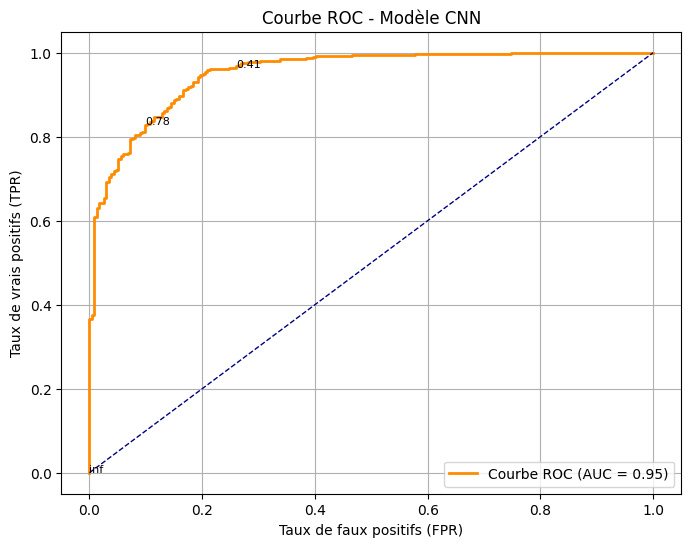

In [ ]:
from sklearn.metrics import roc_curve, auc

# Prédictions sur le jeu de test
y_pred_prob = model.predict(test_data)  # Probabilités de la classe "PNEUMONIA" (positive)

# Récupération des vraies étiquettes
y_true = np.concatenate([labels.numpy() for images, labels in test_data])

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Modèle CNN')
plt.legend(loc="lower right")
plt.grid(True)

plt.show()


**10\. Visualisation de la matrice de confusion**
-------------------------------------

Ce que la matrice de confusion montre :

**Vrais Positifs (TP)** : Les cas où le modèle a correctement prédit la classe positive (par exemple, prédire "pneumonie" quand il y en a effectivement une).

**Faux Positifs (FP)** : Les cas où le modèle a prédit la classe positive alors qu'il s'agissait de la classe négative (par exemple, prédire "pneumonie" quand il n'y en a pas).

**Vrais Négatifs (TN)** : Les cas où le modèle a correctement prédit la classe négative (pas de pneumonie et prédiction correcte).

**Faux Négatifs (FN)** : Les cas où le modèle a prédit la classe négative alors qu'il y avait effectivement une classe positive (par exemple, ne pas prédire "pneumonie" quand il y en avait une).

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


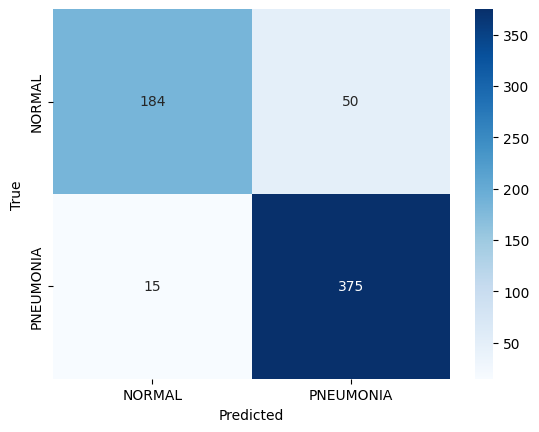

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = np.concatenate([y for x, y in test_data])
y_pred = (model.predict(test_data) > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
model_path = os.path.join(save_dir, "zoidberg_model_v2.h5")
model.save(model_path)
print(f"Modèle sauvegardé au format .h5 dans : {model_path}")

Modèle sauvegardé au format .h5 dans : /content/drive/My Drive/Zoidberg/zoidberg_model_v2.h5
